In [6]:
!pip install tensorflow keras split-folders opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   - -------------------------------------- 1.3/39.5 MB 9.5 MB/s eta 0:00:05
   --- ------------------------------------ 3.4/39.5 MB 9.6 MB/s eta 0:00:04
   ----- ---------------------------------- 5.5/39.5 MB 9.9 MB/s eta 0:00:04
   ------- -------------------------------- 7.6/39.5 MB 9.8 MB/s eta 0:00:04
   ---------- ----------------------------- 10.0/39.5 MB 10.0 MB/s eta 0:00:03
   ------------ --------------------------- 12.1/39.5 MB 9.9 MB/s eta 0:00:03
   -------------- ------------------------- 14.4/39.5 MB 10.1 MB/s eta 0:00:03
   ---------------- ----------------------- 16.5/39.5 MB 10.1 MB/s eta 0:00:03
   ------------------ --------------------- 18.6/39.5 MB 10.0 MB/s eta 0:00:03
   -------------------- ------------------- 20.7/39.5 MB 10.1 MB/s eta 0:00:02
   ---------------------- ----------------- 22.5/39.5 MB 9.9 MB/s eta 0:00:02
   ------------------------ --------------- 24.4/39.5 MB 9.8 MB/s eta 0

In [15]:
import tensorflow as tf
# libraries for comprehensive neural network buidling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
# library for data augmentation and pre processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
# libraries for organizing data and access
import splitfolders
import cv2
# library to ensure that foramt matches the one expected by the model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models

In [19]:
# location directories for input and output
input_folder="/Users/atibp/OneDrive/Desktop/deep-learn-neural-network/agriculture/agricultural-crops"
output_folder="/Users/atibp/OneDrive/Desktop/deep-learn-neural-network/agriculture/agro-images"

# ratio for train, test and validation
split_ratio=[0.8,0.1,0.1]

splitfolders.ratio(
    input_folder,
    output=output_folder,
    # ensures reproducable split
    seed=500,
    ratio=split_ratio,
    group_prefix=None
)

Copying files: 829 files [00:02, 409.25 files/s]


In [28]:
# define image parameters
img_size=(224,244)
batch_size=32

# data augmentation for training data
train_datagen=ImageDataGenerator(
    # input processing method of resnet50
    # scales pixel value to the format expected by pre-trained resnet model
    preprocessing_function=preprocess_input,
    # randomnly rotate image by 20 degree
    rotation_range=20,
    # randomly shift image 20% of width towards left and right
    width_shift_range=0.2,
    # randomly shift image 20% of height towards up and down
    height_shift_range=0.2,
    # random shear transforamtion 
    shear_range=0.2,
    # random zoom by upto 20%
    zoom_range=0.2,
    # randomly flip image horizontally
    horizontal_flip=True,
    # when image randomly shifted or rotated, fill the pixel with nearest values
    fill_mode='nearest'
)

In [30]:
# data augmentation for test data
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
# data augmentation for validation data
valid_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

In [34]:
import os

In [36]:
# directories for images
train_dir=os.path.join(output_folder,'train')
test_dir=os.path.join(output_folder,'val')
valid_dir=os.path.join(output_folder,'test')

# create generators that read images from the directories to applt the specific augmentations in batches
# generate batches of tensor images from specific directory
train_data=train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    # enures that the labels are one hot encoded
    class_mode='categorical'
)

test_data=test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data=valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 652 images belonging to 30 classes.
Found 72 images belonging to 30 classes.
Found 105 images belonging to 30 classes.


In [40]:
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


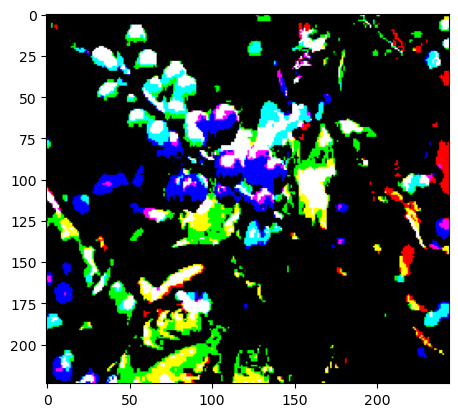

In [42]:
# image and label batch
images,labels=next(valid_data)

# select a random image to display
idx=random.randint(0,images.shape[0]-1)
plt.imshow(images[idx])
plt.show()